# First we initialize the environment:

Requirements installations for linux machine:

In [ ]:
!sudo pip install mtcnn scipy keras_applications mxnet ffmpeg-python face_detection 
!pip install git+https://github.com/yaledhlab/vggface.git
!sudo apt install ffmpeg
!pip install scenedetect[opencv] --upgrade

In [ ]:
# %tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

2.9.2


Now we import modules we need

In [ ]:
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import glob

from sklearn.cluster import DBSCAN, AgglomerativeClustering
from imutils import build_montages
import argparse
import pickle

# import insightface
import urllib
import urllib.request
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from torch import device
from face_detection import build_detector

import os

from imutils import paths
from imutils.video import VideoStream
import imutils
import time

from scipy.spatial import distance as dist
from collections import OrderedDict

from scenedetect import detect, ContentDetector

from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (200, 200)


In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib


Now we make instances of our detecor and feature extractor:

In [ ]:
detector = build_detector('RetinaNetMobileNetV1',
        confidence_threshold = .5, nms_iou_threshold = .3,
        max_resolution = 250)
 

Downloading: "https://folk.ntnu.no/haakohu/RetinaFace_mobilenet025.pth" to /root/.cache/torch/hub/checkpoints/RetinaFace_mobilenet025.pth


  0%|          | 0.00/1.71M [00:00<?, ?B/s]

In [ ]:
# create a vggface model
VGGmodel = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')


94699520/94694792 [==============================] - 11s 0us/step


Now we define classes and functions to detect faces and store them:

In [ ]:
class Face():
    """
    Create an object and update an attribute when it is ready.
    
    constructor params:
        - box: a list like : [x1, y1, x2, y2]
        - confidence: if detector return probability of detected face, put that here.
        - lmarks: put landmarks of face here, 5 or 68 or whatever
        - features: output of FaceRepresentor
        - id: real identity of face
        - pred_id: predicted identity of face

    """
    def __init__(self, box=None, detection_confidence=None,\
                 landmarks=None, embedding=None, id=None):
        self.box = box
        self.confidence = detection_confidence
        self.lmarks = landmarks
        self.id = id
        self.crop = None
        self.features = embedding
        self.pred_id = 0

        
    def __str__(self):
        attrs = vars(self)
        return ', '.join("%s: %s" % item for item in attrs.items())

In [ ]:
def face_detection(image):
    '''
    Face Detection

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        faces (list): The list of faces in the input image.
    '''

    bbox, lmarks = detector.batched_detect_with_landmarks(np.expand_dims(image, axis = 0))
    faces = []
    for i, box in enumerate(bbox[0]):
        f = Face()
        [x1, y1, x2, y2, pr] = box.astype(int)
        f.box = [x1, y1, x2, y2]
        f.lmarks = lmarks[0][i].astype(int)
        faces.append(f)
    return faces

In here we define our Centroid Tracker class:

In [ ]:
class CentroidTracker():
    def __init__(self, maxDisappeared=0):
		# initialize the next unique object ID along with two ordered
		# dictionaries used to keep track of mapping a given object
		# ID to its centroid and number of consecutive frames it has
		# been marked as "disappeared", respectively
        self.nextObjectID = 0 
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
		# store the number of maximum consecutive frames a given
		# object is allowed to be marked as "disappeared" until we
		# need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared

    def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1
        
    def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]
    
    def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
        if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
			# return early as there are no centroids or tracking info
			# to update
            return self.objects
		# initialize an array of input centroids for the current frame
        inputCentroids = np.zeros((len(rects), 2), dtype="int")
		# loop over the bounding box rectangles
        for (i, (startX, startY, endX, endY)) in enumerate(rects):
			# use the bounding box coordinates to derive the centroid
            cX = int((startX + endX) / 2.0)
            cY = int((startY + endY) / 2.0)
            inputCentroids[i] = (cX, cY)
		# if we are currently not tracking any objects take the input
		# centroids and register each of them
        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i])
		# otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
        else:
			# grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())
			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
            D = dist.cdist(np.array(objectCentroids), inputCentroids)
			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value is at the *front* of the index
			# list
            rows = D.min(axis=1).argsort()
			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]
			# in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()
			# loop over the combination of the (row, column) index
			# tuples
            for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
                if row in usedRows or col in usedCols:
                    continue
				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.disappeared[objectID] = 0
				# indicate that we have examined each of the row and
				# column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)
			# compute both the row and column index we have NOT yet
			# examined
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)
			# in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
            if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
                for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1
					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)
			# otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
            else:
                for col in unusedCols:
                    self.register(inputCentroids[col])
		# return the set of trackable objects
        return self.objects

Here we define our shot detection function and Tracking Function which takes a video and reads every frame and then saves unique sequences:

First we make directory to store our detected faces:

In [ ]:
!rm -rf sequences
!mkdir sequences

In [ ]:
scene_start_frame = [0]
def sequence_shot_detect(filename):
    scene_list = detect(filename, ContentDetector())
    for scene in scene_list:
        scene_start_frame.append(scene[1].frame_num)
    print("Shot detection finished! shots detected:", len(scene_start_frame))

In [ ]:
frame_boxes = []
def sequence_save(filename): 

    # initialize our centroid tracker and frame dimensions
    ct = CentroidTracker()
    (H, W) = (None, None)

    # initialize the video stream and allow the camera sensor to warmup
    print("[INFO] starting video stream...")
    cap = cv2.VideoCapture(filename)

    fps = cap.get(cv2.CAP_PROP_FPS) # Gets the frames per second
    print('video fps is: ', fps)

    frameID = 0
    sequencesIDs = []

    # Shot Detect params:
    scene_start_frame_pointer = 1
    fnum = scene_start_frame[scene_start_frame_pointer]
    max_pointer = len(scene_start_frame) - 1

    # loop over the frames from the video stream
    while True:
	    # read the next frame from the video stream and resize it
        ret, frame = cap.read()
        if (not ret):
            break
        
        
        frame = imutils.resize(frame, width=400)
 
	    # if the frame dimensions are None, grab them
        if W is None or H is None:
            (H, W) = frame.shape[:2]
    
        rects = []

        if (frameID == fnum):
            if (scene_start_frame_pointer == max_pointer):
                frameID += 1
                faces = []
                objects = ct.update(rects)
                continue
            else:
                scene_start_frame_pointer += 1
                fnum = scene_start_frame[scene_start_frame_pointer]
                frameID += 1
                faces = []
                objects = ct.update(rects)
                continue


        faces = face_detection(frame)
	    # loop over the detections
        for i in range(len(faces)):
        
            x, y, w, h = faces[i].box
            box = np.array([x, y, w, h])
            rects.append(box.astype("int"))
   
		    # draw a bounding box surrounding the object so we can
		    # visualize it
            (startX, startY, endX, endY) = box.astype("int")
	    # update our centroid tracker using the computed set of bounding
	    # box rectangles
        objects = ct.update(rects)
	    # loop over the tracked objects
        in_frame_ctr = 0
        
        for (objectID, centroid) in objects.items():
            try:
                box = rects[in_frame_ctr]
                # last_rects = rects
            except: 
                print("LOST FACE")

            x, y, w, h = box
            if x < 0:
                x = 0
            if y < 0:
                y = 0
            if w < 0:
                w = 0
            if h < 0:
                h = 0

            if (not objectID in sequencesIDs):
                sequencesIDs.append(objectID)
                cv2.imwrite("/content/sequences/sequence%d_frame%d.jpg" %(objectID, frameID), frame[int(y):int(h), int(x):int(w)])
            else:
                try:
                    cv2.imwrite("/content/sequences/sequence%d_frame%d.jpg" %(objectID, frameID), frame[int(y):int(h), int(x):int(w)])
                except:
                    print("FOUND AN ERROR!")
            
            d = [{
                "fileName": "sequence%d_frame%d.jpg" %(objectID, frameID), 
                "objectID": objectID, 
                "frameID": frameID, 
                "bbox": (int(y), int(h), int(x), int(w))
            }]
            frame_boxes.extend(d)

            text = "ID {}".format(objectID)

            in_frame_ctr += 1


	    # show the output frame
        # cv2_imshow(frame)
        key = cv2.waitKey(1) & 0xFF
	    # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break
        frameID += 1
    # do a bit of cleanup
    cv2.destroyAllWindows()
    # cap.stop()
    print("DONE!")


# Now we iterate over the labled 10 minutes video

In [ ]:
sequence_shot_detect('/content/drive/MyDrive/VideoSamples/mehmuni10.mp4')
sequence_save('/content/drive/MyDrive/VideoSamples/mehmuni10.mp4')

INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154


Shot detection finished! shots detected: 147
[INFO] starting video stream...
video fps is:  25.0
DONE!


In the section below we do a little bit of clean up in the directories of the faces we have detected:

In [ ]:
import os
import shutil

seq_dir = '/content/sequences'


def data_cleaner():
    os.chdir(seq_dir)
    parent_dir = os.getcwd()
    print(parent_dir)
    seq_frames = os.listdir()
    print("total frames detected:" + str(len(seq_frames)))
    # print((seq_frames[0].split('_'))[0].split('sequence')[1])
    sequence_no = 0
    sequences = []
    frame_no = 0
    frames = []
    for i in range(len(seq_frames)):
        seq_no = (seq_frames[i].split('_'))[0].split('sequence')[1]
        if seq_no in sequences:
            shutil.move((parent_dir + '/' + seq_frames[i]), (parent_dir + '/' + 'sequence' + seq_no + '/' + seq_frames[i]))
        else:
            sequences.append(seq_no)
            os.mkdir('sequence' + seq_no)
            shutil.move((parent_dir + '/' + seq_frames[i]), (parent_dir + '/' + 'sequence' + seq_no + '/' +seq_frames[i]))

    print("DONE!")



data_cleaner()

/content/sequences
total frames detected:34008
DONE!


Now we compress the sequences and store them in the drive as a checkpoint:

In [ ]:
!zip -r "sequences_retina_mehmuni10.zip" '/content/sequences'

In [ ]:
!cp -R "/content/sequences/sequences_retina_mehmuni10.zip" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!pwd
!cd ..
!pwd

In [ ]:
os.chdir("/content")

Now we compress the sequences and store them in the drive as a checkpoint:

In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("frame_boxes.pickle", "wb")
f.write(pickle.dumps(frame_boxes))
f.close()

!cp -R "frame_boxes.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R "/content/drive/MyDrive/RetinaFiles/frame_boxes.pickle" '.'
print("COPIED!")

COPIED!


In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
frame_boxes_data = pickle.loads(open("frame_boxes.pickle", "rb").read())
frame_boxes_data = np.array(frame_boxes_data)
frame_boxes_data_bbox = [d["bbox"] for d in frame_boxes_data]

[INFO] loading encodings...


## Now we calculate embeddings for each frame of each sequence

Read the sequences from drive:

In [ ]:
!cp -R "/content/drive/MyDrive/RetinaFiles/sequences_retina_mehmuni10.zip" '.'
print("COPIED!")

In [ ]:
!unzip "sequences_retina_mehmuni10.zip"

In [ ]:
!mv -i "/content/content/sequences" '.'
print("COPIED!")

In [ ]:
seqq1 = glob.glob('/content/sequences/*')
seqq1.sort()
frames_recovered_from_sequences = []
for i in seqq1:
    frames_recovered_from_sequences.extend(glob.glob(i + '/*'))
print(len(frames_recovered_from_sequences))
print(frames_recovered_from_sequences[0])

In [ ]:
sequence_faces = frames_recovered_from_sequences

For extracting first we need to define some preprocess functions:

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


Here we define our embedding neural network to extract feature embeddings:

In [ ]:
# create a vggface model
base_cnn = VGGFace(model='resnet50', include_top=False, input_shape=target_shape + (3,), pooling='avg')

embedding = Model(base_cnn.input, base_cnn.output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_3_1x1_increase":
        trainable = True
    layer.trainable = trainable
    print(layer.name,' ------------------- ', trainable)

In [ ]:
base_cnn.summary()

Now we define a function which reads images and calculates feature embeddings for them using the defined neural network:

In [ ]:
def get_sequence_embeddings(filelist):
    seq_emb_data = []
    faces_result = []
    for f in filelist:
        pixels = cv2.imread(f, 1)
        # resize pixels to the model size
        image = Image.fromarray(pixels)
        image = image.resize(target_shape)
        face_array = asarray(image)
        # faces_result.append(face_array)

        # extract faces
        extracted_face = asarray(face_array, 'float32')
        extracted_face = resnet.preprocess_input(extracted_face)
        extracted_face = np.expand_dims(extracted_face, axis=0)
        emm = embedding(extracted_face)[0]

        objectID = f.split('/')[-1].split('.')[0].split('_')[0].split('sequence')[1]
        frameID = f.split('/')[-1].split('.')[0].split('_')[1].split('frame')[1]

        d = [{
                "imagePath": f, 
                "objectID": objectID, 
                "frameID": frameID, 
                "encoding": emm
            }]
            
        seq_emb_data.extend(d)
    return seq_emb_data

In [ ]:
seq_emb_data = get_sequence_embeddings(sequence_faces)

Now we do some calculations on the data to provide dictionaries for clustering and for creating the triplets for our Siamese network and as we mentioned we store data in pickle files after each iteration and read from them as checkpoints:

In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings.pickle", "wb")
f.write(pickle.dumps(seq_emb_data))
f.close()

!cp -R "sequences_encodings.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data = pickle.loads(open("sequences_encodings.pickle", "rb").read())
seq_emb_data = np.array(seq_emb_data)
seq_emb_data_encodings = [d["encoding"] for d in seq_emb_data]

[INFO] loading encodings...


In [ ]:
seq_emb_data = sorted(seq_emb_data, key=lambda x: int(x['objectID']))

FrameID based sorting:

In [ ]:
seq_emb_data_frameID_dict = {}
i = 0
for item in seq_emb_data:
    i += 1
    imagePath = item["imagePath"]
    frameID = item["frameID"]

    # if "3161" in seq_emb_data_dict:
    if frameID in seq_emb_data_frameID_dict:
        # print(" found")
        d = [item]
        seq_emb_data_frameID_dict[frameID].extend(d)
        # print(seq_emb_data_dict[objectID])
        # print("------------------------------------------------")
    else:
        # print("noooooot foound")
        seq_emb_data_frameID_dict[frameID] = [item]
        # print(seq_emb_data_dict[objectID])
        # print("------------------------------------------------")

print(i)
print("Cell ran")

34008
Cell ran


In [ ]:
print(len(seq_emb_data_frameID_dict))
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_frameids.pickle", "wb")
f.write(pickle.dumps(seq_emb_data_frameID_dict))
f.close()

!cp -R "sequences_encodings_frameids.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

33965
[INFO] serializing encodings...
COPIED!


In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_frameids.pickle' "." 
print("COPIED!")

COPIED!


In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data_frameIDs = pickle.loads(open("sequences_encodings_frameids.pickle", "rb").read())

[INFO] loading encodings...


In [ ]:
seq_emb_data_dict = {}
i = 0
for item in seq_emb_data:
    i += 1
    imagePath = item["imagePath"]
    objectID = item["objectID"]

    if objectID in seq_emb_data_dict:
        d = [item]
        seq_emb_data_dict[objectID].extend(d)
    else:
        seq_emb_data_dict[objectID] = [item]

print(i)
print("Cell ran")

34008
Cell ran


In [ ]:
print(len(seq_emb_data_dict))
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_objectids.pickle", "wb")
f.write(pickle.dumps(seq_emb_data_dict))
f.close()

!cp -R "sequences_encodings_objectids.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

482
[INFO] serializing encodings...
COPIED!


In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_objectids.pickle' "." 
print("COPIED!")

COPIED!


In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data_objectIDs = pickle.loads(open("sequences_encodings_objectids.pickle", "rb").read())

[INFO] loading encodings...


Now we get average of embeddings for each object ID to cluster them:

In [ ]:
seq_data_objectIDs_frameIDs = {}

for i in range(len(seq_emb_data_objectIDs)):
    objectID = seq_emb_data_objectIDs[str(i)][0]["objectID"]
    seq_data_objectIDs_frameIDs[objectID] = []
    for j in range(len(seq_emb_data_objectIDs[str(i)])):
        d = [seq_emb_data_objectIDs[str(i)][j]["frameID"]]
        seq_data_objectIDs_frameIDs[objectID].extend(d)
    # print(objectID)

print("Cell ran!")

Cell ran!


In [ ]:
print(len(seq_data_objectIDs_frameIDs))
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_objectIDs_frameIDs.pickle", "wb")
f.write(pickle.dumps(seq_data_objectIDs_frameIDs))
f.close()

!cp -R "sequences_encodings_objectIDs_frameIDs.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

482
[INFO] serializing encodings...
COPIED!


In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_objectIDs_frameIDs.pickle' "." 
print("COPIED!")

COPIED!


In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_data_objectIDs_frameIDs = pickle.loads(open("sequences_encodings_objectIDs_frameIDs.pickle", "rb").read())

[INFO] loading encodings...


In [ ]:
def intersection_of_lists(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [ ]:
sequences_co_occurrences = {}

for i in range(len(seq_data_objectIDs_frameIDs)):
    objectID = str(i)
    sequences_co_occurrences[objectID] = {
        "frameIDs" : seq_data_objectIDs_frameIDs[objectID],
        "cooccurrences": []
    }
    for j in range(len(seq_data_objectIDs_frameIDs)):
        second_objectID = str(j)
        if i == j:
            continue
        else:
            intersection_result = intersection_of_lists(
                                    seq_data_objectIDs_frameIDs[objectID],
                                    seq_data_objectIDs_frameIDs[second_objectID],
                                    )
            if (len(intersection_result) != 0):
                d = [second_objectID]
                sequences_co_occurrences[objectID]["cooccurrences"].extend(d)

In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_co_occurrences.pickle", "wb") 
f.write(pickle.dumps(sequences_co_occurrences))
f.close()

!cp -R "sequences_encodings_co_occurrences.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_co_occurrences.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
sequences_co_occurrences = pickle.loads(open("sequences_encodings_co_occurrences.pickle", "rb").read())

In [ ]:
seq_emb_data_objectIDs_avg = []
for item in seq_emb_data_objectIDs:
    embs = []
    sum_embs = 0
    for idx in range(len(seq_emb_data_objectIDs[item])):
        embs.append(seq_emb_data_objectIDs[item][idx])
        sum_embs += (seq_emb_data_objectIDs[item][idx]["encoding"])
    
    d = [{
            "objectID": seq_emb_data_objectIDs[item][0]['objectID'],
            "encoding_avg": (sum_embs/len(seq_emb_data_objectIDs[item])),
            "list_of_objects": embs
    }]
    seq_emb_data_objectIDs_avg.extend(d)


In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_objectIDs_avg.pickle", "wb")
f.write(pickle.dumps(seq_emb_data_objectIDs_avg))
f.close()

!cp -R "sequences_encodings_objectIDs_avg.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_objectIDs_avg.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data_objectIDs_avg = pickle.loads(open("sequences_encodings_objectIDs_avg.pickle", "rb").read())
seq_emb_data_objectIDs_avg = np.array(seq_emb_data_objectIDs_avg)
seq_emb_data_objectIDs_avg_encodings = [d["encoding_avg"] for d in seq_emb_data_objectIDs_avg]

Now we cluster the labled video data:

In [ ]:
print("[INFO] clustering...")
print(len(seq_emb_data_objectIDs_avg_encodings[0]))

clt = AgglomerativeClustering(n_clusters = 4)
clt.fit(seq_emb_data_objectIDs_avg_encodings)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

[INFO] clustering...
2048
[INFO] # unique faces: 4


In [ ]:
clustering_objectIDs = {d["objectID"] : None for d in seq_emb_data_objectIDs_avg}

Here we read the lables from drive to calculate the initial NMI

In [ ]:
import pandas as pd

col_list = ["seq_no", "char_no", "other_chars"]
df = pd.read_csv('/content/drive/MyDrive/RetinaFiles/seq_retina_mehmuni10.csv', usecols=col_list)
labels_true = []
for i in (df["char_no"]):
    labels_true.append(i)

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
labels_pred = clt.labels_
print("Before Fine-Tuning NMI:")
normalized_mutual_info_score(labels_true, labels_pred)

In [ ]:
clustering_objectIDs = {d["objectID"] : None for d in seq_emb_data_objectIDs_avg}

for i in range(len(clustering_objectIDs)):
    clustering_objectIDs[str(i)] = clt.labels_[i]

In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_clustering_objectIDs.pickle", "wb")
f.write(pickle.dumps(clustering_objectIDs))
f.close()

!cp -R "sequences_encodings_clustering_objectIDs.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_clustering_objectIDs.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
clustering_objectIDs = pickle.loads(open("sequences_encodings_clustering_objectIDs.pickle", "rb").read())

By running the cell below we can have a visual view of the clusters:

[INFO] faces for face ID: 0


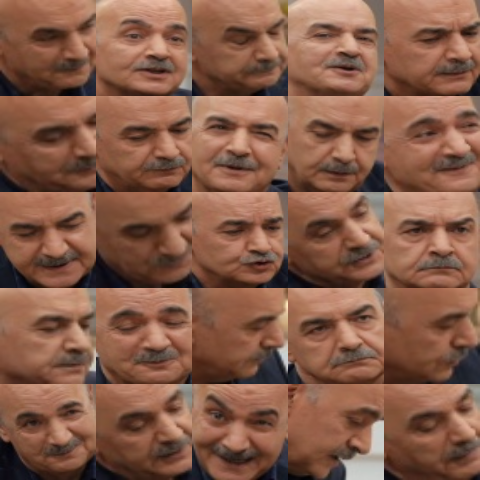

[INFO] faces for face ID: 1


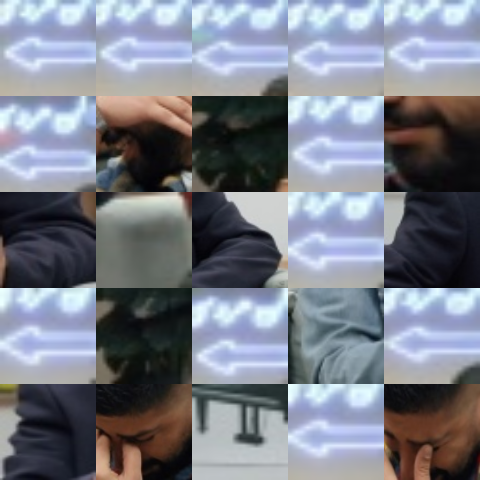

[INFO] faces for face ID: 2


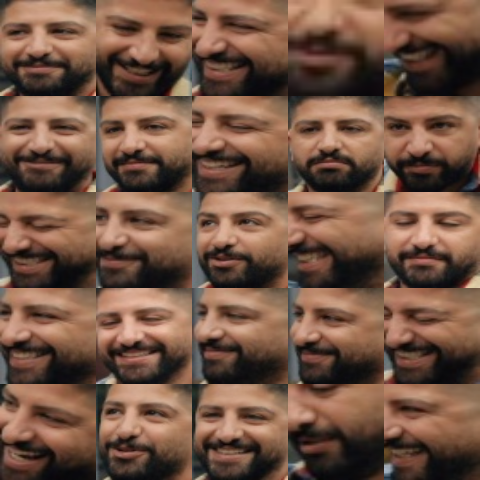

[INFO] faces for face ID: 3


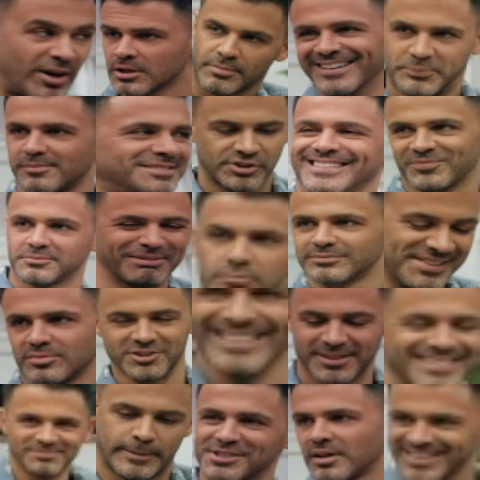

In [ ]:
# loop over the unique face integers
for labelID in labelIDs:
	# find all indexes into the `data` array that belong to the
	# current label ID, then randomly sample a maximum of 25 indexes
	# from the set
    print("[INFO] faces for face ID: {}".format(labelID))
    idxs = np.where(clt.labels_ == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)), replace=False)
	# initialize the list of faces to include in the montage
    faces = []
    # loop over the sampled indexes
    for i in idxs:
		# load the input image and extract the face ROI
        image = cv2.imread(seq_emb_data_objectIDs_avg[i]["list_of_objects"][0]["imagePath"])
        face = image
		# force resize the face ROI to 96x96 and then add it to the
		# faces montage list
        image = cv2.resize(image, (96, 96))
        faces.append(image)
    # create a montage using 96x96 "tiles" with 5 rows and 5 columns
    montage = build_montages(faces, (96, 96), (5, 5))[0]
	
	# show the output montage
    title = "Face ID #{}".format(labelID)
    title = "Unknown Faces" if labelID == -1 else title
    cv2_imshow(montage)
    cv2.waitKey(0)

# Now we should do the whole process again to gather the same info for the 24 minutes long non-labled video to train our Siamese network

In [ ]:
sequence_shot_detect('/content/drive/MyDrive/VideoSamples/mehmuni_train24.mp4')
sequence_save('/content/drive/MyDrive/VideoSamples/mehmuni_train24.mp4')

In the section below we do a little bit of clean up in the directories of the faces we have detected:

In [ ]:
import os
import shutil

seq_dir = '/content/sequences'


def data_cleaner():
    os.chdir(seq_dir)
    parent_dir = os.getcwd()
    print(parent_dir)
    seq_frames = os.listdir()
    print("total frames detected:" + str(len(seq_frames)))
    # print((seq_frames[0].split('_'))[0].split('sequence')[1])
    sequence_no = 0
    sequences = []
    frame_no = 0
    frames = []
    for i in range(len(seq_frames)):
        seq_no = (seq_frames[i].split('_'))[0].split('sequence')[1]
        if seq_no in sequences:
            shutil.move((parent_dir + '/' + seq_frames[i]), (parent_dir + '/' + 'sequence' + seq_no + '/' + seq_frames[i]))
        else:
            sequences.append(seq_no)
            os.mkdir('sequence' + seq_no)
            shutil.move((parent_dir + '/' + seq_frames[i]), (parent_dir + '/' + 'sequence' + seq_no + '/' +seq_frames[i]))

    print("DONE!")



data_cleaner()

Now we compress the sequences and store them in the drive as a checkpoint:

In [ ]:
!zip -r "sequences_retina_mehmuni_train.zip" '/content/sequences'

In [ ]:
!cp -R "/content/sequences/sequences_retina_mehmuni_train.zip" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!pwd
!cd ..
!pwd

In [ ]:
os.chdir("/content")

Now we compress the sequences and store them in the drive as a checkpoint:

In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("frame_boxes.pickle", "wb")
f.write(pickle.dumps(frame_boxes))
f.close()

!cp -R "frame_boxes.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R "/content/drive/MyDrive/RetinaFiles/frame_boxes.pickle" '.'
print("COPIED!")

COPIED!


In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
frame_boxes_data = pickle.loads(open("frame_boxes.pickle", "rb").read())
frame_boxes_data = np.array(frame_boxes_data)
frame_boxes_data_bbox = [d["bbox"] for d in frame_boxes_data]

[INFO] loading encodings...


## Now we calculate embeddings for each frame of each sequence

Read the sequences from drive:

In [ ]:
!cp -R "/content/drive/MyDrive/RetinaFiles/sequences_retina_mehmuni_train.zip" '.'
print("COPIED!")

In [ ]:
!unzip "sequences_retina_mehmuni_train.zip"

In [ ]:
!mv -i "/content/content/sequences" '.'
print("COPIED!")

In [ ]:
seqq1 = glob.glob('/content/sequences/*')
seqq1.sort()
frames_recovered_from_sequences = []
for i in seqq1:
    frames_recovered_from_sequences.extend(glob.glob(i + '/*'))
print(len(frames_recovered_from_sequences))
print(frames_recovered_from_sequences[0])

In [ ]:
sequence_faces = frames_recovered_from_sequences

In [ ]:
seq_emb_data = get_sequence_embeddings(sequence_faces)

Now we do some calculations on the data to provide dictionaries for clustering and for creating the triplets for our Siamese network and as we mentioned we store data in pickle files after each iteration and read from them as checkpoints:

In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings.pickle", "wb")
f.write(pickle.dumps(seq_emb_data))
f.close()

!cp -R "sequences_encodings.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data = pickle.loads(open("sequences_encodings.pickle", "rb").read())
seq_emb_data = np.array(seq_emb_data)
seq_emb_data_encodings = [d["encoding"] for d in seq_emb_data]

[INFO] loading encodings...


In [ ]:
seq_emb_data = sorted(seq_emb_data, key=lambda x: int(x['objectID']))

FrameID based sorting:

In [ ]:
seq_emb_data_frameID_dict = {}
i = 0
for item in seq_emb_data:
    i += 1
    imagePath = item["imagePath"]
    frameID = item["frameID"]

    # if "3161" in seq_emb_data_dict:
    if frameID in seq_emb_data_frameID_dict:
        # print(" found")
        d = [item]
        seq_emb_data_frameID_dict[frameID].extend(d)
        # print(seq_emb_data_dict[objectID])
        # print("------------------------------------------------")
    else:
        # print("noooooot foound")
        seq_emb_data_frameID_dict[frameID] = [item]
        # print(seq_emb_data_dict[objectID])
        # print("------------------------------------------------")

print(i)
print("Cell ran")

In [ ]:
print(len(seq_emb_data_frameID_dict))
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_frameids.pickle", "wb")
f.write(pickle.dumps(seq_emb_data_frameID_dict))
f.close()

!cp -R "sequences_encodings_frameids.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_frameids.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data_frameIDs = pickle.loads(open("sequences_encodings_frameids.pickle", "rb").read())

In [ ]:
seq_emb_data_dict = {}
i = 0
for item in seq_emb_data:
    i += 1
    imagePath = item["imagePath"]
    objectID = item["objectID"]

    if objectID in seq_emb_data_dict:
        d = [item]
        seq_emb_data_dict[objectID].extend(d)
    else:
        seq_emb_data_dict[objectID] = [item]

print(i)
print("Cell ran")

In [ ]:
print(len(seq_emb_data_dict))
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_objectids.pickle", "wb")
f.write(pickle.dumps(seq_emb_data_dict))
f.close()

!cp -R "sequences_encodings_objectids.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_objectids.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data_objectIDs = pickle.loads(open("sequences_encodings_objectids.pickle", "rb").read())

Now we get average of embeddings for each object ID to cluster them:

In [ ]:
seq_data_objectIDs_frameIDs = {}

for i in range(len(seq_emb_data_objectIDs)):
    objectID = seq_emb_data_objectIDs[str(i)][0]["objectID"]
    seq_data_objectIDs_frameIDs[objectID] = []
    for j in range(len(seq_emb_data_objectIDs[str(i)])):
        d = [seq_emb_data_objectIDs[str(i)][j]["frameID"]]
        seq_data_objectIDs_frameIDs[objectID].extend(d)
    # print(objectID)

print("Cell ran!")

In [ ]:
print(len(seq_data_objectIDs_frameIDs))
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_objectIDs_frameIDs.pickle", "wb")
f.write(pickle.dumps(seq_data_objectIDs_frameIDs))
f.close()

!cp -R "sequences_encodings_objectIDs_frameIDs.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_objectIDs_frameIDs.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_data_objectIDs_frameIDs = pickle.loads(open("sequences_encodings_objectIDs_frameIDs.pickle", "rb").read())

In [ ]:
def intersection_of_lists(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [ ]:
sequences_co_occurrences = {}

for i in range(len(seq_data_objectIDs_frameIDs)):
    objectID = str(i)
    sequences_co_occurrences[objectID] = {
        "frameIDs" : seq_data_objectIDs_frameIDs[objectID],
        "cooccurrences": []
    }
    for j in range(len(seq_data_objectIDs_frameIDs)):
        second_objectID = str(j)
        if i == j:
            continue
        else:
            intersection_result = intersection_of_lists(
                                    seq_data_objectIDs_frameIDs[objectID],
                                    seq_data_objectIDs_frameIDs[second_objectID],
                                    )
            if (len(intersection_result) != 0):
                d = [second_objectID]
                sequences_co_occurrences[objectID]["cooccurrences"].extend(d)

In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_co_occurrences.pickle", "wb") 
f.write(pickle.dumps(sequences_co_occurrences))
f.close()

!cp -R "sequences_encodings_co_occurrences.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_co_occurrences.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
sequences_co_occurrences = pickle.loads(open("sequences_encodings_co_occurrences.pickle", "rb").read())

In [ ]:
seq_emb_data_objectIDs_avg = []
for item in seq_emb_data_objectIDs:
    embs = []
    sum_embs = 0
    for idx in range(len(seq_emb_data_objectIDs[item])):
        embs.append(seq_emb_data_objectIDs[item][idx])
        sum_embs += (seq_emb_data_objectIDs[item][idx]["encoding"])
    
    d = [{
            "objectID": seq_emb_data_objectIDs[item][0]['objectID'],
            "encoding_avg": (sum_embs/len(seq_emb_data_objectIDs[item])),
            "list_of_objects": embs
    }]
    seq_emb_data_objectIDs_avg.extend(d)


In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_objectIDs_avg.pickle", "wb")
f.write(pickle.dumps(seq_emb_data_objectIDs_avg))
f.close()

!cp -R "sequences_encodings_objectIDs_avg.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_objectIDs_avg.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data_objectIDs_avg = pickle.loads(open("sequences_encodings_objectIDs_avg.pickle", "rb").read())
seq_emb_data_objectIDs_avg = np.array(seq_emb_data_objectIDs_avg)
seq_emb_data_objectIDs_avg_encodings = [d["encoding_avg"] for d in seq_emb_data_objectIDs_avg]

Now we cluster the labled video data:

In [ ]:
print("[INFO] clustering...")
print(len(seq_emb_data_objectIDs_avg_encodings[0]))

clt = AgglomerativeClustering(n_clusters = 4)
clt.fit(seq_emb_data_objectIDs_avg_encodings)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

[INFO] clustering...
2048
[INFO] # unique faces: 4


In [ ]:
clustering_objectIDs = {d["objectID"] : None for d in seq_emb_data_objectIDs_avg}

for i in range(len(clustering_objectIDs)):
    clustering_objectIDs[str(i)] = clt.labels_[i]

In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("sequences_encodings_clustering_objectIDs.pickle", "wb")
f.write(pickle.dumps(clustering_objectIDs))
f.close()

!cp -R "sequences_encodings_clustering_objectIDs.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_clustering_objectIDs.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
clustering_objectIDs = pickle.loads(open("sequences_encodings_clustering_objectIDs.pickle", "rb").read())

By running the cell below we can have a visual view of the clusters:

In [ ]:
# loop over the unique face integers
for labelID in labelIDs:
	# find all indexes into the `data` array that belong to the
	# current label ID, then randomly sample a maximum of 25 indexes
	# from the set
    print("[INFO] faces for face ID: {}".format(labelID))
    idxs = np.where(clt.labels_ == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)), replace=False)
	# initialize the list of faces to include in the montage
    faces = []
    # loop over the sampled indexes
    for i in idxs:
		# load the input image and extract the face ROI
        image = cv2.imread(seq_emb_data_objectIDs_avg[i]["list_of_objects"][0]["imagePath"])
        face = image
		# force resize the face ROI to 96x96 and then add it to the
		# faces montage list
        image = cv2.resize(image, (96, 96))
        faces.append(image)
    # create a montage using 96x96 "tiles" with 5 rows and 5 columns
    montage = build_montages(faces, (96, 96), (5, 5))[0]
	
	# show the output montage
    title = "Face ID #{}".format(labelID)
    title = "Unknown Faces" if labelID == -1 else title
    cv2_imshow(montage)
    cv2.waitKey(0)

# Now we shall start fine tuning:

## First we should gather our triplet dataset

Anchor list gathering:

In [ ]:
seqq1 = glob.glob('/content/sequences/*')
seqq1.sort()
frames_recovered_from_sequences = []
for i in seqq1:
    frames_recovered_from_sequences.extend(glob.glob(i + '/*'))
print(len(frames_recovered_from_sequences))
print(frames_recovered_from_sequences[0])
anchor_images = sorted(frames_recovered_from_sequences)
print(frames_recovered_from_sequences[0])
print("ANCHORS GATHERED!")

Positive list gathering:

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_objectids.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data_objectIDs = pickle.loads(open("sequences_encodings_objectids.pickle", "rb").read())

In [ ]:
print((seq_emb_data_objectIDs["0"][0]["imagePath"]))

In [ ]:
pos_list = []
for anchor in anchor_images:
    sample = anchor.split('/')[-1].split('.')[0].split('_')
    objectID = sample[0].split('sequence')[-1]
    frameID = sample[1].split('frame')[-1]
    objectID_query = seq_emb_data_objectIDs[str(objectID)]
    random_sample = random.randint(0, (len(objectID_query)-1))
    pos_list.append(objectID_query[random_sample]["imagePath"])
print("POSITIVES GATHERED!")

Negative list gathering:

First thing we check is the existance of another face in the same frame(same frameID) as co-occurring track:

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_objectIDs_frameIDs.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_data_objectIDs_frameIDs = pickle.loads(open("sequences_encodings_objectIDs_frameIDs.pickle", "rb").read())

[INFO] loading encodings...


If none exists we need the data from all co-occurring tracks for the cases where the face does not have co-occurring face in the same frame:

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_co_occurrences.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
sequences_co_occurrences = pickle.loads(open("sequences_encodings_co_occurrences.pickle", "rb").read())

The last option we have is to set a frame from an opossing cluster of tracks randomly:

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/sequences_encodings_clustering_objectIDs.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")    
clustering_objectIDs = pickle.loads(open("sequences_encodings_clustering_objectIDs.pickle", "rb").read())

In [ ]:
neg_list = []
for anchor in anchor_images:
    sample = anchor.split('/')[-1].split('.')[0].split('_')
    objectID = sample[0].split('sequence')[-1]
    frameID = sample[1].split('frame')[-1]
    objectID_co_occurrences = sequences_co_occurrences[str(objectID)]["cooccurrences"]

    if (len(objectID_co_occurrences) > 0):
        objectID_co_occurred = objectID_co_occurrences[random.randint(0, (len(objectID_co_occurrences)-1))]
        objectID_query = seq_emb_data_objectIDs[str(objectID_co_occurred)]
        random_sample = random.randint(0, (len(objectID_query)-1))
        neg_list.append(objectID_query[random_sample]["imagePath"])
    else:
        cluster_of_anchor = clustering_objectIDs[str(objectID)]
        target_objectIDs = []
        for i in range(len(clustering_objectIDs)):
            if clustering_objectIDs[str(i)] != cluster_of_anchor:
                target_objectIDs.append(str(i))
        
        if (len(target_objectIDs) > 0):
            random_sample = random.randint(0, (len(target_objectIDs)-1))
            sample_objectID = target_objectIDs[random_sample]
            objectID_query = seq_emb_data_objectIDs[str(sample_objectID)]
            random_sample = random.randint(0, (len(objectID_query)-1))
            neg_list.append(objectID_query[random_sample]["imagePath"])
        else:
            print("FOUND NO MATCH!!!")

print("Negatives GATHERED!")

In [ ]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = anchor_images

positive_images = pos_list

negative_images = neg_list

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)


dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


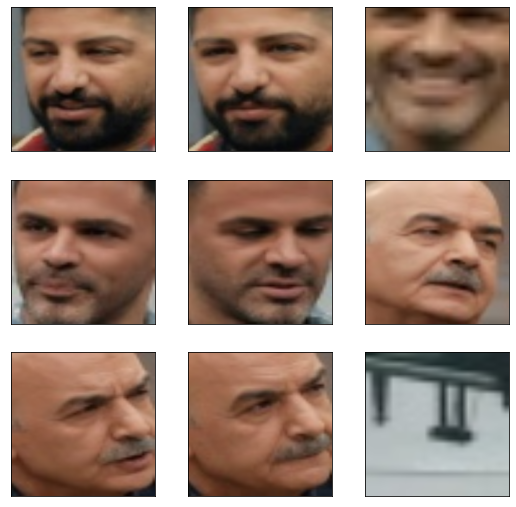

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Setting up the Siamese Network model

The Siamese network will receive each of the triplet images as an input,
generate the embeddings, and output the distance between the anchor and the
positive embedding, as well as the distance between the anchor and the negative
embedding.

To compute the distance, we can use a custom layer `DistanceLayer` that
returns both values as a tuple.

In [ ]:

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

## Putting everything together

We now need to implement a model with custom training loop so we can compute
the triplet loss using the three embeddings produced by the Siamese network.

Let's create a `Mean` metric instance to track the loss of the training process.

In [ ]:

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


## Training

We are now ready to train our model.

In [ ]:
N = 50 # NUM_EPOCHS
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), weighted_metrics=[])
siamese_model.fit(train_dataset, epochs=N, validation_data=val_dataset)

In [ ]:
# serialize the model to disk
print("[INFO] saving model...")
siamese_model.save("/content/drive/MyDrive/RetinaFiles/siamese_model_epoch50")
siamese_model.save("/content/drive/MyDrive/RetinaFiles/siamese_model_epoch50", save_format="h5")

In [ ]:
H = siamese_model
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
plt.savefig("/content/drive/MyDrive/plot_epoch50.png")

## Inspecting what the network has learned

At this point, we can check how the network learned to separate the embeddings
depending on whether they belong to similar images.

Now we use the new weigths of the network to extract feature embeddings for the images of the labled video to check if the clustering accuracy increaces by any chance.

In [ ]:
!cp -R "/content/drive/MyDrive/RetinaFiles/sequences_retina_mehmuni10.zip" '.'
print("COPIED!")

In [ ]:
!rm -rf "/content/content"

In [ ]:
!unzip "sequences_retina_mehmuni10.zip"

In [ ]:
!mv -i "/content/content/sequences" '.'
print("COPIED!")

In [ ]:
seqq1 = glob.glob('/content/content/sequences/*')
seqq1.sort()
frames_recovered_from_sequences = []
for i in seqq1:
    frames_recovered_from_sequences.extend(glob.glob(i + '/*'))
print(len(frames_recovered_from_sequences))
print(frames_recovered_from_sequences[0])

In [ ]:
sequence_faces = frames_recovered_from_sequences

In [ ]:
seq_emb_data = get_sequence_embeddings(sequence_faces)

In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("FNsequences_encodings.pickle", "wb")
f.write(pickle.dumps(seq_emb_data))
f.close()

!cp -R "FNsequences_encodings.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/FNsequences_encodings.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data = pickle.loads(open("FNsequences_encodings.pickle", "rb").read())
seq_emb_data = np.array(seq_emb_data)
seq_emb_data_encodings = [d["encoding"] for d in seq_emb_data]

In [ ]:
seq_emb_data = sorted(seq_emb_data, key=lambda x: int(x['objectID']))

In [ ]:
seq_emb_data_dict = {}
i = 0
for item in seq_emb_data:
    i += 1
    imagePath = item["imagePath"]
    objectID = item["objectID"]

    if objectID in seq_emb_data_dict:
        d = [item]
        seq_emb_data_dict[objectID].extend(d)
    else:
        seq_emb_data_dict[objectID] = [item]

print("Cell ran")

In [ ]:
print(len(seq_emb_data_dict))
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("FNsequences_encodings_objectids.pickle", "wb")
f.write(pickle.dumps(seq_emb_data_dict))
f.close()

!cp -R "FNsequences_encodings_objectids.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/FNsequences_encodings_objectids.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data_objectIDs = pickle.loads(open("FNsequences_encodings_objectids.pickle", "rb").read())

In [ ]:
seq_emb_data_objectIDs_avg = []
for item in seq_emb_data_objectIDs:
    embs = []
    sum_embs = 0
    for idx in range(len(seq_emb_data_objectIDs[item])):
        embs.append(seq_emb_data_objectIDs[item][idx])
        sum_embs += (seq_emb_data_objectIDs[item][idx]["encoding"])
    
    d = [{
            "objectID": seq_emb_data_objectIDs[item][0]['objectID'],
            "encoding_avg": (sum_embs/len(seq_emb_data_objectIDs[item])),
            "list_of_objects": embs
    }]
    seq_emb_data_objectIDs_avg.extend(d)


In [ ]:
# dump the facial encodings data to disk
print("[INFO] serializing encodings...")
f = open("FNsequences_encodings_objectIDs_avg.pickle", "wb")
f.write(pickle.dumps(seq_emb_data_objectIDs_avg))
f.close()

!cp -R "FNsequences_encodings_objectIDs_avg.pickle" '/content/drive/MyDrive/RetinaFiles'
print("COPIED!")

In [ ]:
!cp -R '/content/drive/MyDrive/RetinaFiles/FNsequences_encodings_objectIDs_avg.pickle' "." 
print("COPIED!")

In [ ]:
# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on
# them
print("[INFO] loading encodings...")
seq_emb_data_objectIDs_avg = pickle.loads(open("FNsequences_encodings_objectIDs_avg.pickle", "rb").read())
seq_emb_data_objectIDs_avg = np.array(seq_emb_data_objectIDs_avg)
seq_emb_data_objectIDs_avg_encodings = [d["encoding_avg"] for d in seq_emb_data_objectIDs_avg]

In [ ]:
print("[INFO] clustering...")
print(len(seq_emb_data_objectIDs_avg_encodings[0]))

clt = AgglomerativeClustering(n_clusters = 4)
clt.fit(seq_emb_data_objectIDs_avg_encodings)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

In [ ]:
import pandas as pd

col_list = ["seq_no", "char_no", "other_chars"]
df = pd.read_csv('/content/drive/MyDrive/RetinaFiles/seq_retina_mehmuni10.csv', usecols=col_list)
labels_true = []
for i in (df["char_no"]):
    labels_true.append(i)

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
labels_pred = clt.labels_
# labels_true = [1,2,3,1,2,1,3,1,2,3,1,3,1,2]
print("After Fine-Tuning NMI:")
calculated_nmi_after = normalized_mutual_info_score(labels_true, labels_pred)
print(calculated_nmi_after)

In [ ]:
improvement_percent = (calculated_nmi_after - calculated_nmi)

In [ ]:
print("improvement after fine-tuning epoch1 resnet basenet non-trainable: " + str(improvement_percent*100) + "%")